## Policy Testing Script for Preference-based Policy Iteration (PBPI) Algorithm
### Application on the Inverted pendulum problem

In [1]:
########################################
### importing the necessary packages ###

import gym
from gym import wrappers
import custom_cartpole  # custom cart-pole environment

import numpy as np
import pandas as pd

import random

from scipy.stats import rankdata as rd
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import HTML

import io
import base64
import itertools
import tqdm
import os

########################################

In [2]:
########################################
########## helper functions ##########

# generate a random action from a given environment
def random_action(environment, seed=10):
    """ return a random action from the given environment. """
    
    # set env. seeds for reproducibility
    #environment.action_space.np_random.seed(seed) 
    #environment.seed(seed) 
    
    return environment.action_space.sample()


# generate a list of initial states from a given environment
def generate_init_states_S(seed
                           , env = 'CustomCartPole-v0'):
    """ this function returns a list of randomly generated initial states from a given environment. """
    
    # set the random seed for reproducibility
    np.random.seed(seed)
    
    # define how many states to generate (total)
    n_states = np.random.randint(low=21, high=101) 
    
    # define how many states to generate (sample)
    n_states_sample = np.random.randint(low=20, high=21) 

    # define a list to store the generated initial states
    init_states_S = []

    # create a given environment object
    env = gym.make(env)
    env.action_space.np_random.seed(seed) # set env. seeds for reproducibility
    env.seed(seed) # set env. seeds for reproducibility
    env.reset(init_state = np.array([0,0,0,0]))

    s_count = 0
    # create initial states
    while s_count < n_states:

        # step through the environment
        state, reward, done, info = env.step(env.action_space.sample())  
            
        # if terminates, reset the environment
        # and continue to next step (without appending to state list)
        # increment 'n_states' count by 1
        # remove the last 1 state(s) from the appended list (avoid having states close to termination)
        if done: 
            env.reset(init_state = np.array([0,0,0,0]))
            n_states+=7
            init_states_S = init_states_S[:-7]
            continue
            
        # append the geneareted state to list
        init_states_S.append(state)
        
        s_count +=1
      
    env.close()
    
    # remove any duplicate state values from the list
    state_str_li = []
    for state in init_states_S:
        state_str_li.append("".join([str(item[0]) for item in [item.reshape(-1) for item in state.flatten()]]))

    uniq, uni_id = np.unique(state_str_li, return_index=True)

    init_states_S = [init_states_S[j] for j in uni_id]
    
    # sample selected number of states
    sampled_states = random.sample(init_states_S, n_states_sample)
            
    return sampled_states
    #return init_states_S
    

# partition the action space of a given environment 
def partition_action_space(env_name:'string'
                           , n_actions:'int'):
    """function to partitions the action space of an environment into a given number of actions`"""
    
    # initialize environment
    env = gym.make(env_name)

    # partition the action space to a given number of actions
    part_act_space = np.linspace(env.action_space.low[0,0]
                                 ,env.action_space.high[0,0],n_actions)
    
    return part_act_space  


########################################

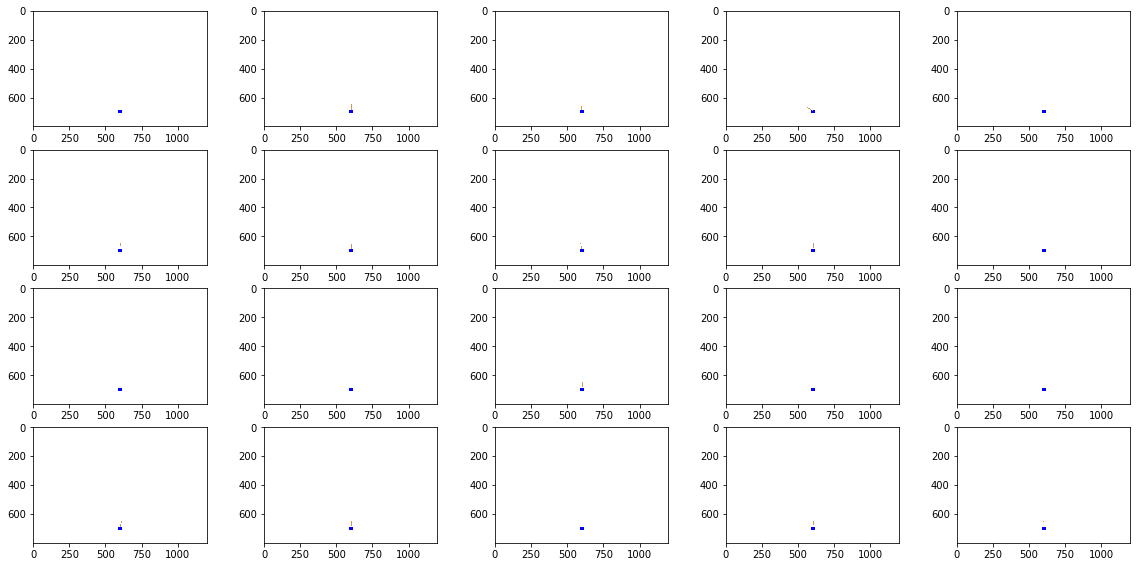

In [3]:
########################################
########### EXTRA : EXAMPLES ###########

# generate a list of sample states and plot 40 states
init_states_S = generate_init_states_S(2, env='CustomCartPole-v0')

env = gym.make('CustomCartPole-v0')
env = env.unwrapped # unwrap the environment to set custom initial states
fig = plt.figure(figsize=(20,20))

for i in range(20):
    env.state = init_states_S[i] # set state
    fig.add_subplot(8,5,i+1)
    plt.imshow(env.render(mode="rgb_array"))
    env.close()
    
plt.show()

########################################

### Preference-based (approximate) policy iteration algorithm

This algorithm includes two main functions and a class:
 - `evaluate_preference` (func) : this function generates roll-outs to create preferences between pairs of actions at each initial states.
 - `train_model` (func) : this function uses the generated preference data to estimate the `LabelRanker` model.
 - `Policy` (class) : this class takes the trained `LabelRanker` model and generate a policy for the agent to follow.

In [4]:
########################################
### Derived policy using LabelRanker ###

class Policy():
    
    """
    Description:
    
        - This Policy object takes a given neural network (LabelRanker) model and uses it to define a policy for the agent to follow
    """
    
    def __init__(self, action_space, model, probs):
        self.action_space = action_space # action space of the current environment
        self.model = model               # trained NN (LabelRanker) model
        self.probs = probs               # list of probabilities for actions
        
    def label_ranking_policy(self,obs):
        """ Produces an action for a given state based on the LabelRanker model prediction
            Note: only the pendulum-angle and pendulum-velocity of the input state are considered when producing an action
        
            At each input state:
                - Highest ranked action is selected with a prob. of 0.95
                - Second highest ranked action is selected with a prob. of 0.04
                - Any remaining actions are selected with an equal proabability of .01 """


        # only select the pendulum-velocity and angle from the input state vector
        #state_obs = np.array([obs[2].reshape(-1)[0],obs[3].reshape(-1)[0]]) 
        #state_obs = np.array([round(obs[2].reshape(-1)[0],6),round(obs[3].reshape(-1)[0],6)]) # rounded input
        state_obs = np.array([obs[2].reshape(-1)[0],obs[3].reshape(-1)[0]])
        
        #state_obs = state_obs.reshape(-1,state_obs.shape[0]) # reshape to be a 2D array
        state_obs = torch.from_numpy(state_obs) # convert to a tensor

        # make ranking predictions for all actions
        with torch.no_grad():
            preds = self.model(state_obs.float()) 

        # rank the indexes of actions (from highest ranked/preferred action to lowest)
        #ranked_action_idx = (-rd(preds.detach().numpy())).argsort()[:preds.shape[1]]
        ranked_action_idx = (-rd(preds.detach().numpy())).argsort()

        
        ### return the selected action ###
        
        # if there are more than 2 actions
        if len(self.action_space)>2:
            
            # compute the probabilities for the 3rd action onward
            remain_probs = .00/len(ranked_action_idx[2:])
            n_remain_actions = ranked_action_idx.shape[0]-2

            # since we add random noise to action, policy becomes stochastic (even if we select the 1st ranked action always)
            # select one of the remaining actions 1% time
            action = np.random.choice(ranked_action_idx,1 , p=[self.probs[0], self.probs[1]] + list(np.repeat(remain_probs,n_remain_actions)))[0]
        
        else:
            
            # if there are only 2 actions: select highest preferred actions 95% and 5% of the time
            action = np.random.choice(ranked_action_idx,1 , p=[self.probs[0], self.probs[1]])[0]
        
        # when action space is partitioned, return the corresponding action
        # - a uniform noise term is added to action signals to make all state transitions non-deterministic 
        # clip action value to (-1,1) range
        return np.array([[np.clip(self.action_space[int(action)] + np.array(np.random.uniform(low = -.2,high=.2),dtype=float),-1,1)]])
    

########################################

In [6]:
# create the environment and action space
seed = 2 
model_name = 'cartPole_original' # name for the LabelRanker model

env = gym.make('CustomCartPole-v0')   # environment
sample_states = generate_init_states_S(seed, env='CustomCartPole-v0') # initial state list
act_space = partition_action_space('CustomCartPole-v0',3) # action space

class Model(nn.Module):

    def __init__(self, input_state_len, output_label_len, layers, p=0.3):

        super(Model,self).__init__()

        all_layers = []
        input_size = input_state_len

        # create layers
        for layer_dim in layers:
            all_layers.append(nn.Linear(input_size, layer_dim))
            all_layers.append(nn.LeakyReLU(inplace=True))
            #all_layers.append(nn.BatchNorm1d(layer_dim))
            #all_layers.append(nn.Dropout(p))
            input_size = layer_dim

        all_layers.append(nn.Linear(layers[-1], output_label_len))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, state_vec):
        x = self.layers(state_vec)
        return x


# create a NN model instance
model = Model(2, 3,[50])

# load the model
PATH = f"./models/{model_name}_pbpi_model.pt" 
model.load_state_dict(torch.load(PATH))
model.eval()


# create policy
policy = Policy(act_space,model,[1.0,0.0])

# apply policy and record frames
env = wrappers.Monitor(env, "./gym-results", force=True)
obs = env.reset()

for _ in range(2000):
    action = policy.label_ranking_policy(obs)
    observation, reward, done, info = env.step(action)
    obs = observation
    if done: break
env.close()

# observe policy performance
video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))


#### Simulations at each initial state

In [ ]:
b_episodes = 1
nb_timesteps = 300
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

max_reward = 0

#np.random.seed()
env = env.unwrapped
for state in sample_states:
    #env.state = init_states_S[np.random.randint(0,len(init_states_S))]

    env.state = state
    for episode in range(nb_episodes):  # iterate over the episodes
        state = env.reset()             # initialise the environment
        rewards = []

        for t in range(nb_timesteps):    # iterate over time steps
            #env.render()                 # display the environment
            img.set_data(env.render(mode='rgb_array')) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)
            action = policy.label_ranking_policy(obs)
            observation, reward, done, info = env.step(np.array([[+1]]))
            obs = observation
            rewards.append(reward)      # add 1 to the rewards list

            if done: # the episode ends either if the pole is > 15 deg from vertical or the cart move by > 2.4 unit from the centre
                cumulative_reward = sum(rewards)
                print("episode {} finished after {} timesteps. Total reward: {}".format(episode, t+1, cumulative_reward)) 
                max_reward = max(max_reward,sum(rewards))
                break
    

    env.close()

print(max_reward)